In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import random
import time
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import initializers
from tensorflow.keras import Model
from tensorflow.keras.layers import Flatten, Dense
from sklearn.metrics import accuracy_score
from tensorflow.math import log_sigmoid

In [2]:
# Load MNIST
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Select binary data
label_sub = [0,1]
x_train_sub = [x for x, y in zip(x_train, y_train) if y in label_sub]
y_train_sub = [y for y in y_train if y in label_sub]
x_test_sub = [x for x, y in zip(x_test, y_test) if y in label_sub]
y_test_sub = [y for y in y_test if y in label_sub]


print('There are', len(x_train_sub), 'training images.')
print('There are', len(x_test_sub), 'test images.')

There are 12665 training images.
There are 2115 test images.


In [3]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train_sub, y_train_sub)).shuffle(10000).batch(32)
test_ds = tf.data.Dataset.from_tensor_slices((x_test_sub, y_test_sub)).batch(32)

In [4]:
def convert2_zero_one(x):

    t = [tf.math.sigmoid(i) for i in x]
    
    return t

def rerange(x, r = 6.0):
    
    out_of_range = tf.cast(tf.math.greater(tf.math.abs(x), r), tf.float32)
    sign = tf.math.sign(x)
    
    return x * (1 - out_of_range) + sign * r * out_of_range

In [5]:
# MLP model
class StochasticMLP(Model):
    
    def __init__(self, hidden_layer_sizes = [100, 50], n_outputs=10):
        super(StochasticMLP, self).__init__()
        self.hidden_layer_sizes = hidden_layer_sizes
        self.fc_layers = [Dense(layer_size) for layer_size in hidden_layer_sizes]
        self.output_layer = Dense(n_outputs)
        
    def call(self, x):

        x = Flatten()(x)
        network = []
        
        for i, layer in enumerate(self.fc_layers):
            
            logits = layer(x)
            x = tfp.distributions.Bernoulli(logits=logits).sample()
            network.append(x)

        final_logits = self.output_layer(x) # initial the weight of output layer
            
        return network
    
    def target_log_prob(self, x, h, y):
        
        x = Flatten()(x)
        y = [[i] for i in y]
        h_current = convert2_zero_one([tf.cast(h_i, dtype=tf.float32) for h_i in h])
        h_previous = [x] + h_current[:-1]
    
        nlog_prob = 0. # negative log probability
        
        for i, (cv, pv, layer) in enumerate(
            zip(h_current, h_previous, self.fc_layers)):
            
            ce = tf.nn.sigmoid_cross_entropy_with_logits(
                labels=cv, logits=layer(pv))
            
            nlog_prob += tf.reduce_sum(ce, axis = -1)
        
        fce = tf.nn.sigmoid_cross_entropy_with_logits(
            labels=tf.cast(y, tf.float32), logits=self.output_layer(h_current[-1]))
        nlog_prob += tf.reduce_sum(fce, axis = -1)
            
        return -1 * nlog_prob

    def target_log_prob2(self, x, h, y):
        
        x = Flatten()(x)
        y = [[i] for i in y]
        h_current = convert2_zero_one(tf.split(h, self.hidden_layer_sizes, axis = 1))
        #h_current = [h_current[0]]
        h_previous = [x] + h_current[:-1]
        
        nlog_prob = 0.
        
        for i, (cv, pv, layer) in enumerate(
            zip(h_current, h_previous, self.fc_layers)):
            
            ce = tf.nn.sigmoid_cross_entropy_with_logits(
                labels=cv, logits=layer(pv))
            
            nlog_prob += tf.reduce_sum(ce, axis = -1)
        
        fce = tf.nn.sigmoid_cross_entropy_with_logits(
            labels=tf.cast(y, tf.float32), logits=self.output_layer(h_current[-1]))
        nlog_prob += tf.reduce_sum(fce, axis = -1)
            
        return -1 * nlog_prob
    
    def generate_hmc_kernel(self, x, y, step_size = pow(1000, -1/4)):
        
        adaptive_hmc = tfp.mcmc.SimpleStepSizeAdaptation(tfp.mcmc.HamiltonianMonteCarlo(
            target_log_prob_fn = lambda v: self.target_log_prob2(x, v, y),
            num_leapfrog_steps = 2,
            step_size = step_size),
            num_adaptation_steps=int(100 * 0.8))
        
        return adaptive_hmc
    
    # new proposing-state method with HamiltonianMonteCarlo
    def propose_new_state_hamiltonian(self, x, h, y, hmc_ker):
    
        h_current = h
        h_current = [tf.cast(h_i, dtype=tf.float32) for h_i in h_current]
        h_current = tf.concat([h[0], h[1]], axis=1)

        # initialize the HMC transition kernel
        
        adaptive_hmc = tfp.mcmc.SimpleStepSizeAdaptation(tfp.mcmc.HamiltonianMonteCarlo(
            target_log_prob_fn = lambda v: self.target_log_prob2(x, v, y),
            num_leapfrog_steps = 2,
            step_size = pow(1000, -1/4)),
            num_adaptation_steps=int(100*0.8))

        # run the chain (with burn-in)
        num_results = 1
        num_burnin_steps = 100

        samples = tfp.mcmc.sample_chain(
            num_results = num_results,
            num_burnin_steps = num_burnin_steps,
            current_state = h_current, # may need to be reshaped
            kernel = adaptive_hmc,
            trace_fn = None)

        h_new = tf.split(samples[0], self.hidden_layer_sizes, axis = 1)

        return(h_new)
    
    def update_weights(self, x, h, y, lr = 0.1):
        
        optimizer = tf.keras.optimizers.SGD(learning_rate = lr)
        with tf.GradientTape() as tape:
            loss = -1 * tf.reduce_mean(self.target_log_prob(x, h, y))
        
        grads = tape.gradient(loss, self.trainable_weights)
        optimizer.apply_gradients(zip(grads, self.trainable_weights))

    def get_predictions(self, x):

        x = Flatten()(x)
        logits = 0.0
        for layer in self.fc_layers:
            logits = layer(x)
            x = tf.math.sigmoid(logits)
        
        logits = self.output_layer(x)
        probs = tf.math.sigmoid(logits)
        #print(probs)
        labels = tf.cast(tf.math.greater(probs, 0.5), tf.int32)

        return labels

In [6]:
model = StochasticMLP(hidden_layer_sizes = [100, 50], n_outputs = 1)

In [7]:
network = [model.call(images) for images, labels in train_ds]

In [8]:
network[0]

[<tf.Tensor: shape=(32, 100), dtype=int32, numpy=
 array([[1, 1, 1, ..., 0, 0, 0],
        [1, 0, 1, ..., 0, 0, 1],
        [1, 0, 1, ..., 0, 1, 1],
        ...,
        [1, 1, 1, ..., 0, 0, 1],
        [0, 1, 1, ..., 1, 0, 1],
        [0, 0, 1, ..., 1, 0, 1]], dtype=int32)>,
 <tf.Tensor: shape=(32, 50), dtype=int32, numpy=
 array([[0, 0, 1, ..., 0, 0, 0],
        [1, 1, 0, ..., 0, 0, 0],
        [0, 1, 0, ..., 0, 0, 0],
        ...,
        [0, 1, 0, ..., 0, 1, 0],
        [0, 1, 0, ..., 0, 1, 1],
        [0, 0, 1, ..., 1, 1, 0]], dtype=int32)>]

In [9]:
tlp = [model.target_log_prob(images, network[bs], labels) for bs, (images, labels) in enumerate(train_ds)]

In [10]:
kernels = [model.generate_hmc_kernel(images, labels) for images, labels in train_ds]

/Users/hmy/anaconda3/envs/deeplearning/lib/python3.6/site-packages/tensorflow_probability/python/__init__.py:74: UserWarning: TensorFloat-32 matmul/conv are enabled for NVIDIA Ampere+ GPUs. The resulting loss of precision may hinder MCMC convergence. To turn off, run `tf.config.experimental.enable_tensor_float_32_execution(False)`. For more detail, see https://github.com/tensorflow/community/pull/287.
  'TensorFloat-32 matmul/conv are enabled for NVIDIA Ampere+ GPUs. The '


In [ ]:
burnin = 20
step_sizes = []
for i in range(burnin):
    
    print(i)
    network_new = []
    kernels_new = []
    start_time = time.time()
    
    for (images, labels), net, hmc_kernel in zip(train_ds, network, kernels):
        net_current = net
        net_current = [tf.cast(net_i, dtype=tf.float32) for net_i in net_current]
        #net_current = tf.concat([net_current[0], net_current[1]], axis=1)
        net_current = tf.concat(net_current, axis = 1)
        #print(net_current)
        num_results = 1
        num_burnin_steps = 0

        samples = tfp.mcmc.sample_chain(
            num_results = num_results,
            num_burnin_steps = num_burnin_steps,
            current_state = net_current, # may need to be reshaped
            kernel = hmc_kernel,
            #trace_fn = lambda _, pkr: pkr.inner_results.accepted_results.new_step_size,
            trace_fn = None,
            return_final_kernel_results = True)
        
        #print(samples[2].new_step_size.numpy())
        new_step_size = samples[2].new_step_size.numpy()
        step_sizes.append(new_step_size)

        new_state = rerange(samples[0][0])
        net_new = tf.split(new_state, [100, 50], axis = 1)   
        network_new.append(net_new)
        
        # build new kernel
        ker_new = model.generate_hmc_kernel(images, labels, new_step_size)
        kernels_new.append(ker_new)
            
    network = network_new
    kernels = kernels_new
    
    print("Step %d - time %.4f" % (i, time.time()-start_time))

In [19]:
np.shape(step_sizes)

(7920,)

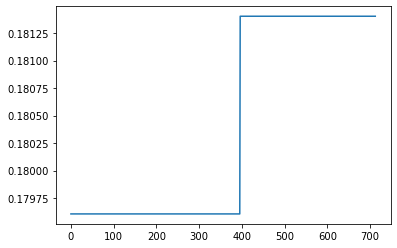

In [12]:
import matplotlib.pyplot as plt
plt.plot(np.arange(len(step_sizes)), step_sizes)
plt.show()

In [14]:
epochs = 500

start_time = time.time()
for epoch in range(epochs):
    
    loss = 0.0
    acc = 0.0
    for bs, (images, labels) in enumerate(train_ds):
        
        # only one mini-batch
        model.update_weights(images, network[bs], labels, 0.1)
        network_new = [model.propose_new_state_hamiltonian(images, net, labels) for (images, labels), net in 
                       zip(train_ds, network)]
        
        network_new = []
        #kernels_new = []
        for net, hmc_kernel in zip(network, kernels):
            net_current = net
            net_current = [tf.cast(net_i, dtype=tf.float32) for net_i in net_current]
            net_current = tf.concat(net_current, axis = 1)
            
            num_results = 1
            num_burnin_steps = 0

            samples = tfp.mcmc.sample_chain(
                num_results = num_results,
                num_burnin_steps = num_burnin_steps,
                current_state = net_current, # may need to be reshaped
                kernel = hmc_kernel,
                trace_fn = None,
                return_final_kernel_results = True)

            #new_step_size = samples[2].new_step_size.numpy()
            
            new_state = rerange(samples[0][0])
            net_new = tf.split(new_state, [100, 50], axis = 1)   
            network_new.append(net_new)
            
            #ker_new = model.generate_hmc_kernel(images2, labels2, new_step_size)
            #kernels_new.append(ker_new)
            
        network = network_new
        #kernels = kernels_new

        loss += -1 * tf.reduce_mean(model.target_log_prob(images, network[bs], labels))
       
    preds = [model.get_predictions(images) for images, labels in train_ds]
    #print(preds)
    train_acc = accuracy_score(np.array(preds[0]), y_train)
    print("Epoch %d/%d: - %.4fs/step - loss: %.4f - accuracy: %.4f" 
          % (epoch + 1, epochs, (time.time() - start_time) / (epoch + 1), loss, train_acc))

TypeError: propose_new_state_hamiltonian() missing 1 required positional argument: 'hmc_ker'